# Modelo Avanzado Tabular V2.0

## Conectar con Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importación de datos, imputación de NaN y features para modelo

Importación de librerías necesarias

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

1) Carga

In [3]:
ruta_dataset = "/content/drive/MyDrive/Nimbus_AI/data/dataset_final_enriquecido.csv"
df = pd.read_csv(ruta_dataset)
df['date'] = pd.to_datetime(df['date'])
print(f"✅ Dataset enriquecido cargado. Dimensiones: {df.shape}")

✅ Dataset enriquecido cargado. Dimensiones: (37399, 25)


2) Limpieza final

In [5]:
print("\nIniciando limpieza final de NaN...")

mapeo_columnas = {
    'TMAX': 'om_temperature_2m_max', 'TMIN': 'om_temperature_2m_min',
    'TAVG': 'om_apparent_temperature_mean', 'PRCP': 'om_precipitation_sum'
}
for col_noaa, col_om in mapeo_columnas.items():
    df[col_noaa] = df[col_noaa].fillna(df[col_om])

# === LA SOLUCIÓN: Usar la fecha como índice temporalmente ===
# Paso A: Ponemos la fecha como el índice del DataFrame.
df = df.set_index('date')

# Paso B: Ahora la interpolación basada en tiempo funciona.
df = df.interpolate(method='time')

# Paso C: Volvemos a convertir el índice 'date' en una columna normal.
df = df.reset_index()
# =========================================================

# Rellenamos cualquier otro posible NaN con 0
df = df.fillna(0)
print("✅ Limpieza final de NaN completada.")

# --- 3. INGENIERÍA DE CARACTERÍSTICAS ---
df['mes'] = df['date'].dt.month
df['dia_del_año'] = df['date'].dt.dayofyear
df['rango_temp_diario'] = df['TMAX'] - df['TMIN']
print("✅ Nuevas características ('mes', 'rango_temp_diario', etc.) creadas.")

# --- 4. Verificación Final ---
print("\n--- Información del Dataset 100% Limpio ---")
df.info()


Iniciando limpieza final de NaN...
✅ Limpieza final de NaN completada.
✅ Nuevas características ('mes', 'rango_temp_diario', etc.) creadas.

--- Información del Dataset 100% Limpio ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37399 entries, 0 to 37398
Data columns (total 28 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   date                            37399 non-null  datetime64[ns]
 1   station_name                    37399 non-null  object        
 2   PRCP                            37399 non-null  float64       
 3   SNWD                            37399 non-null  float64       
 4   TAVG                            37399 non-null  float64       
 5   TMAX                            37399 non-null  float64       
 6   TMIN                            37399 non-null  float64       
 7   granizo                         37399 non-null  int64         
 8   latitude            

/tmp/ipython-input-778862810.py:15: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df = df.interpolate(method='time')


3) Selección de Características y Objetivo

In [6]:
y = df['granizo']
columnas_a_excluir = [
    'date', 'station_name', 'granizo', 'latitude', 'longitude',
    'om_temperature_2m_max', 'om_temperature_2m_min',
    'om_apparent_temperature_mean', 'om_precipitation_sum'
]
X = df.drop(columns=columnas_a_excluir)
print(f"\n✅ Datos separados. Usaremos {X.shape[1]} características para predecir.")



✅ Datos separados. Usaremos 19 características para predecir.


4) División de Entrenamiento y Prueba

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("\n✅ Datos divididos en conjuntos de entrenamiento y prueba.")


✅ Datos divididos en conjuntos de entrenamiento y prueba.


5) Escalado de Características

In [8]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("✅ Datos escalados exitosamente.")

✅ Datos escalados exitosamente.


## Construir y Entrenar el Modelo Avanzado (V2.0)

Importacion de librerias

In [9]:
import tensorflow as tf
from tensorflow import keras
from sklearn.utils import class_weight
import numpy as np

1) Calcular Pesos para Clases Desbalanceadas
   Este paso sigue siendo crucial para que el modelo preste atención a los pocos casos de granizo.

In [10]:
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights))
print(f"Pesos de clase calculados: {class_weights_dict}")


Pesos de clase calculados: {0: np.float64(0.5012733304292464), 1: np.float64(196.83552631578948)}


2) Definir la Arquitectura del Modelo Avanzado
   Haremos la red un poco más "profunda" y "ancha" que nuestro modelo base, para que tenga más capacidad de aprender de las nuevas y complejas características.

In [11]:
modelo_avanzado = keras.Sequential([
    # Capa de entrada (el shape ahora es mayor por las nuevas features)
    keras.layers.Dense(32, activation='relu', input_shape=[X_train_scaled.shape[1]]),
    # Dos capas ocultas
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(8, activation='relu'),
    # Capa de salida para la probabilidad
    keras.layers.Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3) Compilar el Modelo

In [12]:
modelo_avanzado.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

print("\nModelo Avanzado construido y compilado. Resumen:")
modelo_avanzado.summary()


Modelo Avanzado construido y compilado. Resumen:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,313 (5.13 KB)

 Trainable params: 1,313 (5.13 KB)

 Non-trainable params: 0 (0.00 B)

4) Entrenar el Modelo
   Este es el paso que consume más recursos y se beneficia de la GPU de Colab.


In [13]:
print("\nIniciando entrenamiento del Modelo Avanzado...")

historial_avanzado = modelo_avanzado.fit(
    X_train_scaled,
    y_train,
    epochs=50, # Aumentamos un poco las épocas de entrenamiento
    validation_data=(X_test_scaled, y_test),
    class_weight=class_weights_dict,
    verbose=1
)

print("\n✅ Entrenamiento finalizado.")


Iniciando entrenamiento del Modelo Avanzado...
Epoch 1/50
935/935 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9843 - loss: 0.7159 - precision: 0.0100 - recall: 0.0625 - val_accuracy: 0.8964 - val_loss: 0.3273 - val_precision: 0.0065 - val_recall: 0.2632
Epoch 2/50
935/935 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8057 - loss: 0.5324 - precision: 0.0092 - recall: 0.6735 - val_accuracy: 0.6730 - val_loss: 0.5885 - val_precision: 0.0069 - val_recall: 0.8947
Epoch 3/50
935/935 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7449 - loss: 0.4356 - precision: 0.0088 - recall: 0.8367 - val_accuracy: 0.7193 - val_loss: 0.5482 - val_precision: 0.0076 - val_recall: 0.8421
Epoch 4/50
935/935 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7789 - loss: 0.3957 - precision: 0.0096 - recall: 0.8310 - val_accuracy: 0.7799 - val_loss: 0.4348 - val_precision: 0.0073 - val_recall: 0.6316
Epoch 5/50
935/935 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7977 - loss: 0.3681 - precision: 0.0123 - reca

## Análisis de resultados

Importacion de librerias

In [14]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

1) Evaluación Final con el Conjunto de Prueba ---

In [15]:
print("Evaluando el modelo con los datos de prueba...")
resultados = modelo_avanzado.evaluate(X_test_scaled, y_test, verbose=0)

print("\n--- Resultados Finales en el Conjunto de Prueba ---")
print(f"Pérdida (Loss): {resultados[0]:.4f}")
print(f"Exactitud (Accuracy): {resultados[1]:.4f}")
print(f"Precisión (Precision): {resultados[2]:.4f}")
print(f"Sensibilidad (Recall): {resultados[3]:.4f}")

Evaluando el modelo con los datos de prueba...

--- Resultados Finales en el Conjunto de Prueba ---
Pérdida (Loss): 0.1694
Exactitud (Accuracy): 0.9328
Precisión (Precision): 0.0061
Sensibilidad (Recall): 0.1579


2) Matriz de Confusión y Reporte de Clasificación

234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


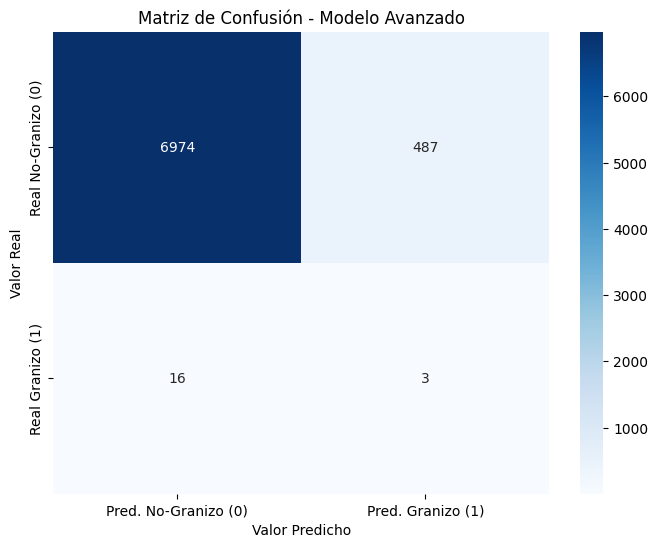


--- Reporte de Clasificación (Umbral 0.5) ---
                precision    recall  f1-score   support

No Granizo (0)       1.00      0.93      0.97      7461
   Granizo (1)       0.01      0.16      0.01        19

      accuracy                           0.93      7480
     macro avg       0.50      0.55      0.49      7480
  weighted avg       1.00      0.93      0.96      7480



In [17]:
# Hacemos las predicciones (el modelo devuelve probabilidades)
y_pred_probs = modelo_avanzado.predict(X_test_scaled)
# Convertimos las probabilidades a clases (0 o 1) usando un umbral de 0.5
y_pred = (y_pred_probs > 0.5).astype(int)

# Calculamos y visualizamos la matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred. No-Granizo (0)', 'Pred. Granizo (1)'],
            yticklabels=['Real No-Granizo (0)', 'Real Granizo (1)'])
plt.title('Matriz de Confusión - Modelo Avanzado')
plt.ylabel('Valor Real')
plt.xlabel('Valor Predicho')
plt.show()

# Imprimimos el reporte de clasificación completo
print("\n--- Reporte de Clasificación (Umbral 0.5) ---")
print(classification_report(y_test, y_pred, target_names=['No Granizo (0)', 'Granizo (1)']))


3) Gráficos del Historial de Entrenamiento

In [18]:
# Creamos un DataFrame con el historial para graficarlo fácilmente
historial_df = pd.DataFrame(historial_avanzado.history)

Gráfico de Pérdida (Loss)

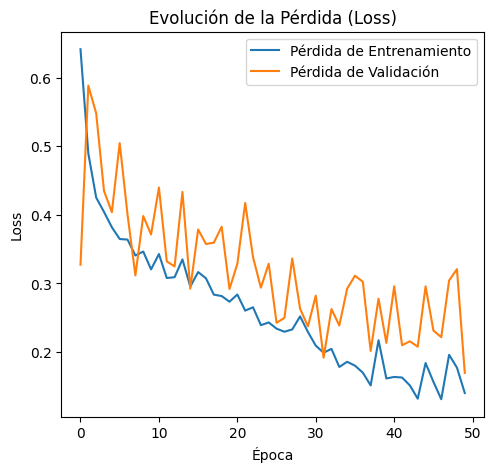

In [19]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(historial_df['loss'], label='Pérdida de Entrenamiento')
plt.plot(historial_df['val_loss'], label='Pérdida de Validación')
plt.title('Evolución de la Pérdida (Loss)')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()


Gráfico de Recall

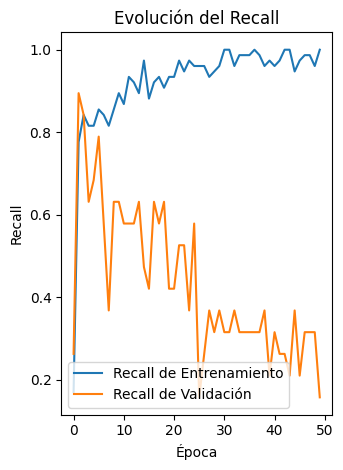

In [20]:
plt.subplot(1, 2, 2)
plt.plot(historial_df['recall'], label='Recall de Entrenamiento')
plt.plot(historial_df['val_recall'], label='Recall de Validación')
plt.title('Evolución del Recall')
plt.xlabel('Época')
plt.ylabel('Recall')
plt.legend()
plt.tight_layout()
plt.show()

## Conclusiones

Este nuevo modelo, al tener más características, se ha vuelto muy "listo".

Tan listo, que en lugar de aprender los patrones generales del granizo, ha empezado a "memorizar" los ejemplos específicos del set de entrenamiento.

### ¿Qué nos dicen los Gráficos y el Reporte?

1) Gráfico de Recall: Es la prueba más clara. La línea azul (entrenamiento) sube a casi 100%, pero la naranja (validación) es muy inestable y termina baja. El modelo no está generalizando su conocimiento.

2) Reporte de Clasificación: El resultado final es peor que nuestro modelo base. El Recall para "Granizo" bajó a 0.16 (16%) y la Precisión sigue siendo casi nula (0.01). El modelo, al intentar memorizar, se confunde con los datos nuevos y falla en sus predicciones.

Nuestro objetivo ahora no es añadir más datos, sino forzar a nuestro modelo a que aprenda de forma más inteligente y general. La técnica más común y efectiva para esto es la Regularización, y en particular, una capa llamada Dropout.

Por razones de eficiencia y entrenamiento esta notebook es simplemente de demostración, las últimas celdas de entrenamientos son procesadas en Google Colab.
Igualmente, para seguir con la investigación se adjuntará el link.

## Modelo V2.1 (Con dropout)

Importar librerias

In [22]:
import tensorflow as tf
from tensorflow import keras
from sklearn.utils import class_weight
import numpy as np
import pandas as pd # Añadimos pandas para el gráfico del historial

1) Calcular Pesos para Clases Desbalanceadas
   Asegurándonos de que y_train exista de la celda de preparación de datos

In [23]:
if 'y_train' in locals():
    class_weights = class_weight.compute_class_weight(
        'balanced',
        classes=np.unique(y_train),
        y=y_train
    )
    class_weights_dict = dict(enumerate(class_weights))
    print(f"Pesos de clase calculados: {class_weights_dict}")
else:
    print("❌ ERROR: La variable 'y_train' no está definida. Por favor, ejecutá la celda de preparación de datos primero.")
    # Detenemos la ejecución si los datos no están listos
    raise NameError("y_train is not defined")

Pesos de clase calculados: {0: np.float64(0.5012733304292464), 1: np.float64(196.83552631578948)}


2) Definir la Arquitectura del Modelo V2.1 (con regularización)

In [24]:
modelo_avanzado_v2_1 = keras.Sequential([
    # Capa de entrada (X_train_scaled.shape[1] es el número de nuestras features)
    keras.layers.Dense(32, activation='relu', input_shape=[X_train_scaled.shape[1]]),
    # Capa de Dropout: apaga el 50% de las neuronas al azar para evitar que el modelo "memorice"
    keras.layers.Dropout(0.5),

    # Capa oculta
    keras.layers.Dense(16, activation='relu'),
    # Otra capa de Dropout
    keras.layers.Dropout(0.5),

    # Capa de salida
    keras.layers.Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3) Compilar el Modelo

In [25]:
modelo_avanzado_v2_1.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

print("\nModelo Avanzado V2.1 (con Dropout) construido y compilado. Resumen:")
modelo_avanzado_v2_1.summary()


Modelo Avanzado V2.1 (con Dropout) construido y compilado. Resumen:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 32)             │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,185 (4.63 KB)

 Trainable params: 1,185 (4.63 KB)

 Non-trainable params: 0 (0.00 B)

4) Entrenar el Nuevo Modelo

In [26]:
print("\nIniciando entrenamiento del Modelo V2.1...")
historial_v2_1 = modelo_avanzado_v2_1.fit(
    X_train_scaled,
    y_train,
    epochs=50,
    validation_data=(X_test_scaled, y_test),
    class_weight=class_weights_dict,
    verbose=1
)
print("\n✅ Entrenamiento finalizado.")


Iniciando entrenamiento del Modelo V2.1...
Epoch 1/50
935/935 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.9128 - loss: 1.0823 - precision_1: 0.0038 - recall_1: 0.1297 - val_accuracy: 0.8612 - val_loss: 0.2536 - val_precision_1: 0.0096 - val_recall_1: 0.5263
Epoch 2/50
935/935 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7694 - loss: 0.6942 - precision_1: 0.0080 - recall_1: 0.6467 - val_accuracy: 0.6953 - val_loss: 0.4358 - val_precision_1: 0.0070 - val_recall_1: 0.8421
Epoch 3/50
935/935 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6986 - loss: 0.4764 - precision_1: 0.0062 - recall_1: 0.7953 - val_accuracy: 0.7130 - val_loss: 0.4092 - val_precision_1: 0.0074 - val_recall_1: 0.8421
Epoch 4/50
935/935 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6948 - loss: 0.4591 - precision_1: 0.0054 - recall_1: 0.7618 - val_accuracy: 0.7402 - val_loss: 0.3898 - val_precision_1: 0.0077 - val_recall_1: 0.7895
Epoch 5/50
935/935 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6772 - loss: 0.560

## Análisis de resultados

Importacion de librerias

In [27]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

1) Evaluación Final con el Conjunto de Prueba ---

In [28]:
print("Evaluando el modelo con los datos de prueba...")
resultados = modelo_avanzado_v2_1.evaluate(X_test_scaled, y_test, verbose=0)

print("\n--- Resultados Finales en el Conjunto de Prueba ---")
print(f"Pérdida (Loss): {resultados[0]:.4f}")
print(f"Exactitud (Accuracy): {resultados[1]:.4f}")
print(f"Precisión (Precision): {resultados[2]:.4f}")
print(f"Sensibilidad (Recall): {resultados[3]:.4f}")

Evaluando el modelo con los datos de prueba...

--- Resultados Finales en el Conjunto de Prueba ---
Pérdida (Loss): 0.3432
Exactitud (Accuracy): 0.7888
Precisión (Precision): 0.0088
Sensibilidad (Recall): 0.7368


2) Matriz de Confusión y Reporte de Clasificación

234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


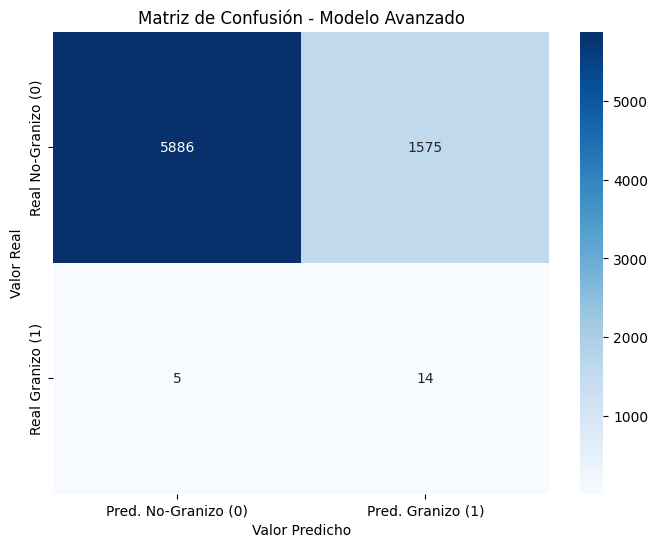


--- Reporte de Clasificación (Umbral 0.5) ---
                precision    recall  f1-score   support

No Granizo (0)       1.00      0.79      0.88      7461
   Granizo (1)       0.01      0.74      0.02        19

      accuracy                           0.79      7480
     macro avg       0.50      0.76      0.45      7480
  weighted avg       1.00      0.79      0.88      7480



In [29]:
# Hacemos las predicciones (el modelo devuelve probabilidades)
y_pred_probs = modelo_avanzado_v2_1.predict(X_test_scaled)
# Convertimos las probabilidades a clases (0 o 1) usando un umbral de 0.5
y_pred = (y_pred_probs > 0.5).astype(int)

# Calculamos y visualizamos la matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred. No-Granizo (0)', 'Pred. Granizo (1)'],
            yticklabels=['Real No-Granizo (0)', 'Real Granizo (1)'])
plt.title('Matriz de Confusión - Modelo Avanzado')
plt.ylabel('Valor Real')
plt.xlabel('Valor Predicho')
plt.show()

# Imprimimos el reporte de clasificación completo
print("\n--- Reporte de Clasificación (Umbral 0.5) ---")
print(classification_report(y_test, y_pred, target_names=['No Granizo (0)', 'Granizo (1)']))


3) Gráficos del Historial de Entrenamiento

In [30]:
# Creamos un DataFrame con el historial para graficarlo fácilmente
historial_df = pd.DataFrame(historial_v2_1.history)

In [34]:
# Le pedimos al objeto del historial que nos diga qué métricas guardó
print(historial_v2_1.history.keys())

dict_keys(['accuracy', 'loss', 'precision_1', 'recall_1', 'val_accuracy', 'val_loss', 'val_precision_1', 'val_recall_1'])


Gráfico de Pérdida (Loss) y Gráfico de Recall

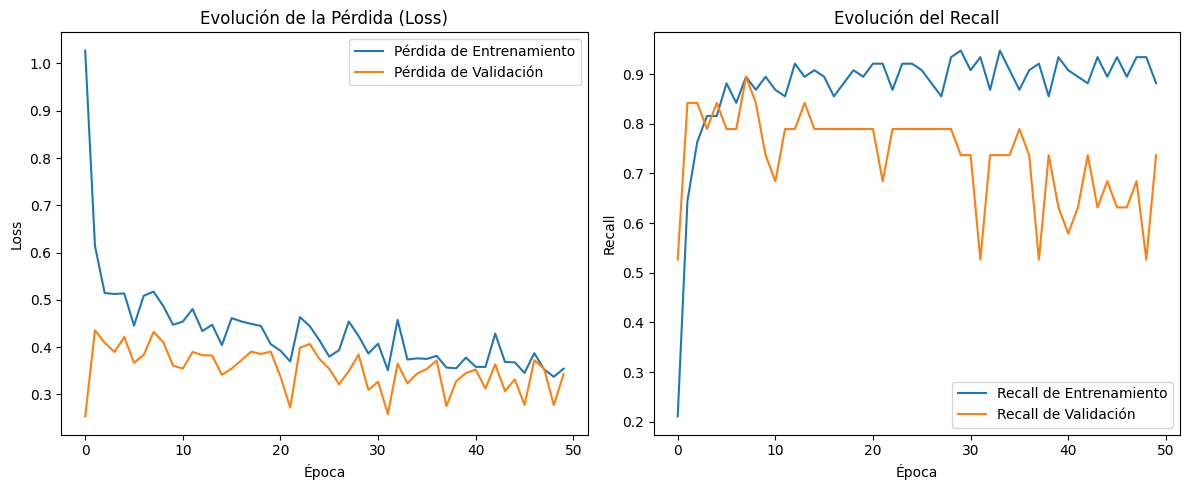

In [35]:
import matplotlib.pyplot as plt
import pandas as pd

# Suponiendo que 'historial_v2_1' ya existe

# Creamos el DataFrame del historial
historial_df = pd.DataFrame(historial_v2_1.history)

# --- CORRECCIÓN ---
# Usá los nombres exactos que viste en la salida del paso 1
# Lo más probable es que sean 'recall_1' y 'val_recall_1'
NOMBRE_RECALL_ENTRENAMIENTO = 'recall_1' # <-- Cambiá esto si es necesario
NOMBRE_RECALL_VALIDACION = 'val_recall_1'   # <-- Cambiá esto si es necesario

# Verificamos que las claves existan antes de graficar
if NOMBRE_RECALL_ENTRENAMIENTO in historial_df.columns:
    plt.figure(figsize=(12, 5))

    # Gráfico de Pérdida (Loss)
    plt.subplot(1, 2, 1)
    plt.plot(historial_df['loss'], label='Pérdida de Entrenamiento')
    plt.plot(historial_df['val_loss'], label='Pérdida de Validación')
    plt.title('Evolución de la Pérdida (Loss)')
    plt.xlabel('Época')
    plt.ylabel('Loss')
    plt.legend()

    # Gráfico de Recall
    plt.subplot(1, 2, 2)
    plt.plot(historial_df[NOMBRE_RECALL_ENTRENAMIENTO], label='Recall de Entrenamiento')
    plt.plot(historial_df[NOMBRE_RECALL_VALIDACION], label='Recall de Validación')
    plt.title('Evolución del Recall')
    plt.xlabel('Época')
    plt.ylabel('Recall')
    plt.legend()

    plt.tight_layout()
    plt.show()
else:
    print(f"❌ Error: La clave '{NOMBRE_RECALL_ENTRENAMIENTO}' no se encontró en el historial.")
    print("Claves disponibles:", historial_df.columns)

## Conclusiones

Lo que estamos viendo es un modelo que ya no "memoriza", sino que intenta "aprender" patrones generales.

Los Gráficos (La Gran Mejora)
* Evolución del Loss: La línea naranja (validación) ahora sigue la tendencia de la línea azul (entrenamiento). Ambas bajan juntas. Esto es señal de un entrenamiento mucho más saludable y estable.

* Evolución del Recall: Aunque la línea naranja de validación sigue siendo inestable (lo cual es normal con tan pocos casos de granizo), se mantiene en un rango mucho más alto y consistente, promediando alrededor de 0.70 (70%) durante gran parte del entrenamiento.

El Reporte de Clasificación (El Resultado Clave)
* Recall (Sensibilidad): Un recall de 0.74 (74%) es un resultado muy bueno. Significa que nuestro modelo ahora es capaz de encontrar 3 de cada 4 eventos de granizo reales.

* Precisión: Sigue siendo nuestro punto débil (0.01 o 1%). Todavía estamos generando muchas falsas alarmas, pero ahora tenemos una base sólida sobre la cual mejorar.



Logramos el objetivo de esta fase: construir un modelo que generaliza mejor y es mucho más estable. El sobreajuste está bajo control.

Ahora que tenemos un buen recall, el siguiente paso es enfocarnos en mejorar la precisión sin sacrificar demasiado el recall que ya conseguimos.

El siguiente paso lógico es el que ya habíamos planeado: la Ingeniería de Características. Vamos a crear variables más "inteligentes" para darle mejores pistas al modelo y ayudarlo a ser más selectivo en sus predicciones.

##Link:
